# Predicting the sine with a LSTM

In [1]:
import keras
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import typing

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM

from sklearn.metrics import mean_squared_error

/Users/dp/.virtualenvs/keras-manning/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## The task

We want to train a neural network to predict values from a simple function: the sine.

In [2]:
def create_sine_sample(n_samples = 5000, sampling_rate = 10) -> pd.DataFrame:
    if not sampling_rate:
        raise ValueError("`sampling_rate` must not be zero.")
    if not n_samples > 0:
        raise ValueError("`n_samples` must be positive integer.")
    
    n_samples = 5000
    ts = pd.DataFrame([np.sin(t / sampling_rate) for t in range(0, n_samples)], columns=["sine"])
    
    return ts

In [3]:
ts = create_sine_sample()

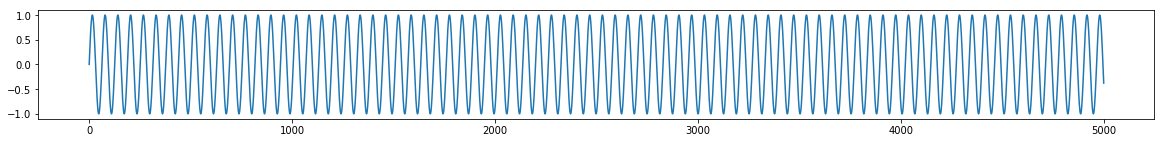

In [4]:
plt.figure(figsize=(20, 2));
plt.plot(ts);

We divide the data in windows of length `window_size`. To make this a supervised problem we label each window with the next data point ahead. Thus we learn to predict one value ahead based on the last `window_size` number of values.

### Setting up the 3D input tensor for the LSTM

Input for a LSTM in Keras is a 3D tensor `T` of shape `(n_samples, n_time_steps, n_input_features)`.
* Here: 
    + `n_samples` is the total number of available data points
    + `n_time_steps` is the number of time steps
    + `n_input_features` is the number of features presented in each time step  
* In our case we want the `(window_size,1)` tensor `T[i,:,:]` to be the window of length `window_size` that starts at `ts[i]`. So `T[i,:,:]` corresponds to `ts[i:i+window_size+1]` (plus reshaping). Thus
    + `n_samples = 5000` (or `ts.shape[0]`)
    + `n_time_steps=window_size`
    + `n_input_features=1`

### Creating the windows

We use the following helper function to produce the desired windows collected as rows in a data frame:

In [5]:
def make_windows(ts: pd.Series, window_size = 50, dropna=True) -> pd.DataFrame:
    df = pd.DataFrame(ts)
    df.index.names = ["Window"]
    
    for i in range(0, window_size):
        ts_shifted = ts.shift(-(i+1))
        ts_shifted.rename(columns={
            "sine":"sine_lag_{}".format(i+1)
        }, inplace=True)
        df = pd.concat([df, ts_shifted], axis=1)
     
    if dropna:
        df.dropna(axis=0, inplace=True)
    
    return df

In [6]:
windows = make_windows(ts)

Looking at the head and tail of the resulting data frame we can clearly see what happens. Note that we drop all rows that contain `na` values by default (these corresponding to windows that jut out beyond the given data).

In [7]:
windows.head()

,sine,sine_lag_1,sine_lag_2,sine_lag_3,sine_lag_4,sine_lag_5,sine_lag_6,sine_lag_7,sine_lag_8,sine_lag_9,...,sine_lag_41,sine_lag_42,sine_lag_43,sine_lag_44,sine_lag_45,sine_lag_46,sine_lag_47,sine_lag_48,sine_lag_49,sine_lag_50
Window,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.099833,0.198669,0.295520,0.389418,0.479426,0.564642,0.644218,0.717356,0.783327,...,-0.818277,-0.871576,-0.916166,-0.951602,-0.977530,-0.993691,-0.999923,-0.996165,-0.982453,-0.958924
1,0.099833,0.198669,0.295520,0.389418,0.479426,0.564642,0.644218,0.717356,0.783327,0.841471,...,-0.871576,-0.916166,-0.951602,-0.977530,-0.993691,-0.999923,-0.996165,-0.982453,-0.958924,-0.925815
2,0.198669,0.295520,0.389418,0.479426,0.564642,0.644218,0.717356,0.783327,0.841471,0.891207,...,-0.916166,-0.951602,-0.977530,-0.993691,-0.999923,-0.996165,-0.982453,-0.958924,-0.925815,-0.883455
3,0.295520,0.389418,0.479426,0.564642,0.644218,0.717356,0.783327,0.841471,0.891207,0.932039,...,-0.951602,-0.977530,-0.993691,-0.999923,-0.996165,-0.982453,-0.958924,-0.925815,-0.883455,-0.832267
4,0.389418,0.479426,0.564642,0.644218,0.717356,0.783327,0.841471,0.891207,0.932039,0.963558,...,-0.977530,-0.993691,-0.999923,-0.996165,-0.982453,-0.958924,-0.925815,-0.883455,-0.832267,-0.772764


In [8]:
windows.tail()

,sine,sine_lag_1,sine_lag_2,sine_lag_3,sine_lag_4,sine_lag_5,sine_lag_6,sine_lag_7,sine_lag_8,sine_lag_9,...,sine_lag_41,sine_lag_42,sine_lag_43,sine_lag_44,sine_lag_45,sine_lag_46,sine_lag_47,sine_lag_48,sine_lag_49,sine_lag_50
Window,,,,,,,,,,,,,,,,,,,,,
4945,-0.955087,-0.979899,-0.994920,-1.000000,-0.995088,-0.980234,-0.955585,-0.921389,-0.877986,-0.825811,...,0.791483,0.726512,0.654281,0.575514,0.490995,0.401571,0.308135,0.211620,0.112990,0.013232
4946,-0.979899,-0.994920,-1.000000,-0.995088,-0.980234,-0.955585,-0.921389,-0.877986,-0.825811,-0.765385,...,0.726512,0.654281,0.575514,0.490995,0.401571,0.308135,0.211620,0.112990,0.013232,-0.086659
4947,-0.994920,-1.000000,-0.995088,-0.980234,-0.955585,-0.921389,-0.877986,-0.825811,-0.765385,-0.697311,...,0.654281,0.575514,0.490995,0.401571,0.308135,0.211620,0.112990,0.013232,-0.086659,-0.185684
4948,-1.000000,-0.995088,-0.980234,-0.955585,-0.921389,-0.877986,-0.825811,-0.765385,-0.697311,-0.622270,...,0.575514,0.490995,0.401571,0.308135,0.211620,0.112990,0.013232,-0.086659,-0.185684,-0.282854
4949,-0.995088,-0.980234,-0.955585,-0.921389,-0.877986,-0.825811,-0.765385,-0.697311,-0.622270,-0.541011,...,0.490995,0.401571,0.308135,0.211620,0.112990,0.013232,-0.086659,-0.185684,-0.282854,-0.377197


### Setting up training and test data

In [9]:
def make_train_test_split(ts, test_ratio=0.2):
    n_samples = ts.shape[0]
    n_row = round(0.8 * n_samples)
    train = ts.iloc[:n_row, :]
    test = ts.iloc[n_row:,:]
    
    windows = make_windows(ts, dropna=True)
    
    X = windows.iloc[:,:-1]
    y = windows.iloc[:,-1]
    
    X_train = X.iloc[:n_row,:].values
    y_train = y.iloc[:n_row].values
    
    X_test = X.iloc[n_row:,:].values
    y_test = y.iloc[n_row:].values
    
    return X_train, X_test, y_train, y_test

In [10]:
X_train, X_test, y_train, y_test = make_train_test_split(ts)

In [11]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4000, 50)
(4000,)
(950, 50)
(950,)


As said above the first LSTM layer expects a 3D tensor. We use `window_size` many time-steps and one input feature per time step. So we still need to reshape our data correspondingly:

In [12]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [13]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4000, 50, 1)
(4000,)
(950, 50, 1)
(950,)


In [14]:
model = Sequential()
model.add(LSTM(input_shape = (50,1), 
               units = 50, 
               return_sequences = True))
model.add(Dropout(0.5))
model.add(LSTM(250))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation("linear"))
model.compile(loss="mse", optimizer="adam")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 250)               301000    
_________________________________________________________________
dropout_2 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 251       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 311,651
Trainable params: 311,651
Non-trainable params: 0
_________________________________________________________________


In [15]:
start = time.time()
model.fit(X_train,
          y_train,
          batch_size=512,
          epochs=3,
          validation_split=0.1)
print("Training Time: {} secs".format(time.time() - start))

Train on 3600 samples, validate on 400 samples
Epoch 1/3
3600/3600 [==============================] - 5s 1ms/step - loss: 0.2907 - val_loss: 0.0360
Epoch 2/3
3600/3600 [==============================] - 4s 1ms/step - loss: 0.0318 - val_loss: 0.0068
Epoch 3/3
3600/3600 [==============================] - 4s 1ms/step - loss: 0.0197 - val_loss: 0.0052
Training Time: 14.851166009902954 secs


In [16]:
preds = model.predict(X_test)

In [17]:
preds.shape

(950, 1)

In [18]:
mean_squared_error(y_test, preds)

0.0053841498797330516

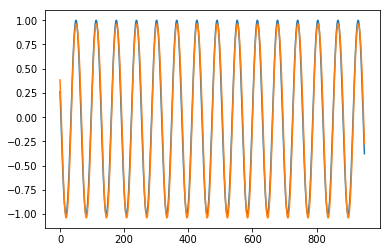

In [19]:
plt.plot(y_test)
plt.plot(preds)
plt.show()